In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


# Define geometry of single element model

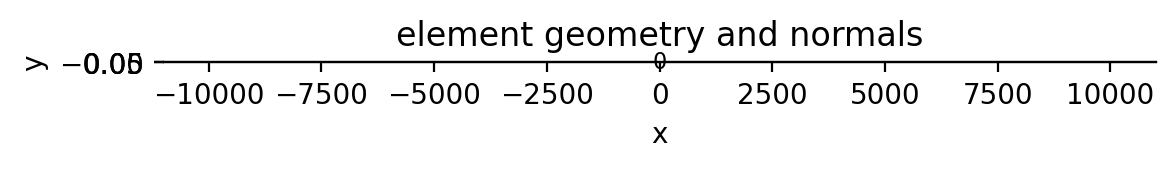

In [2]:
# List of elements for forward model
n_els = 1
mu = 3e10
nu = 0.25
L = 10000
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_els)
els = bemcs.initialize_els()
els.x1 = np.copy(x1)
els.y1 = np.copy(y1)
els.x2 = np.copy(x2)
els.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els)
bemcs.plot_els_geometry(els)

# Observation coordinates

In [3]:
n_pts = 300
width = 20000
x_obs = np.linspace(-width, width, n_pts)
y_obs = np.linspace(-width, width, n_pts)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Single constant slip element

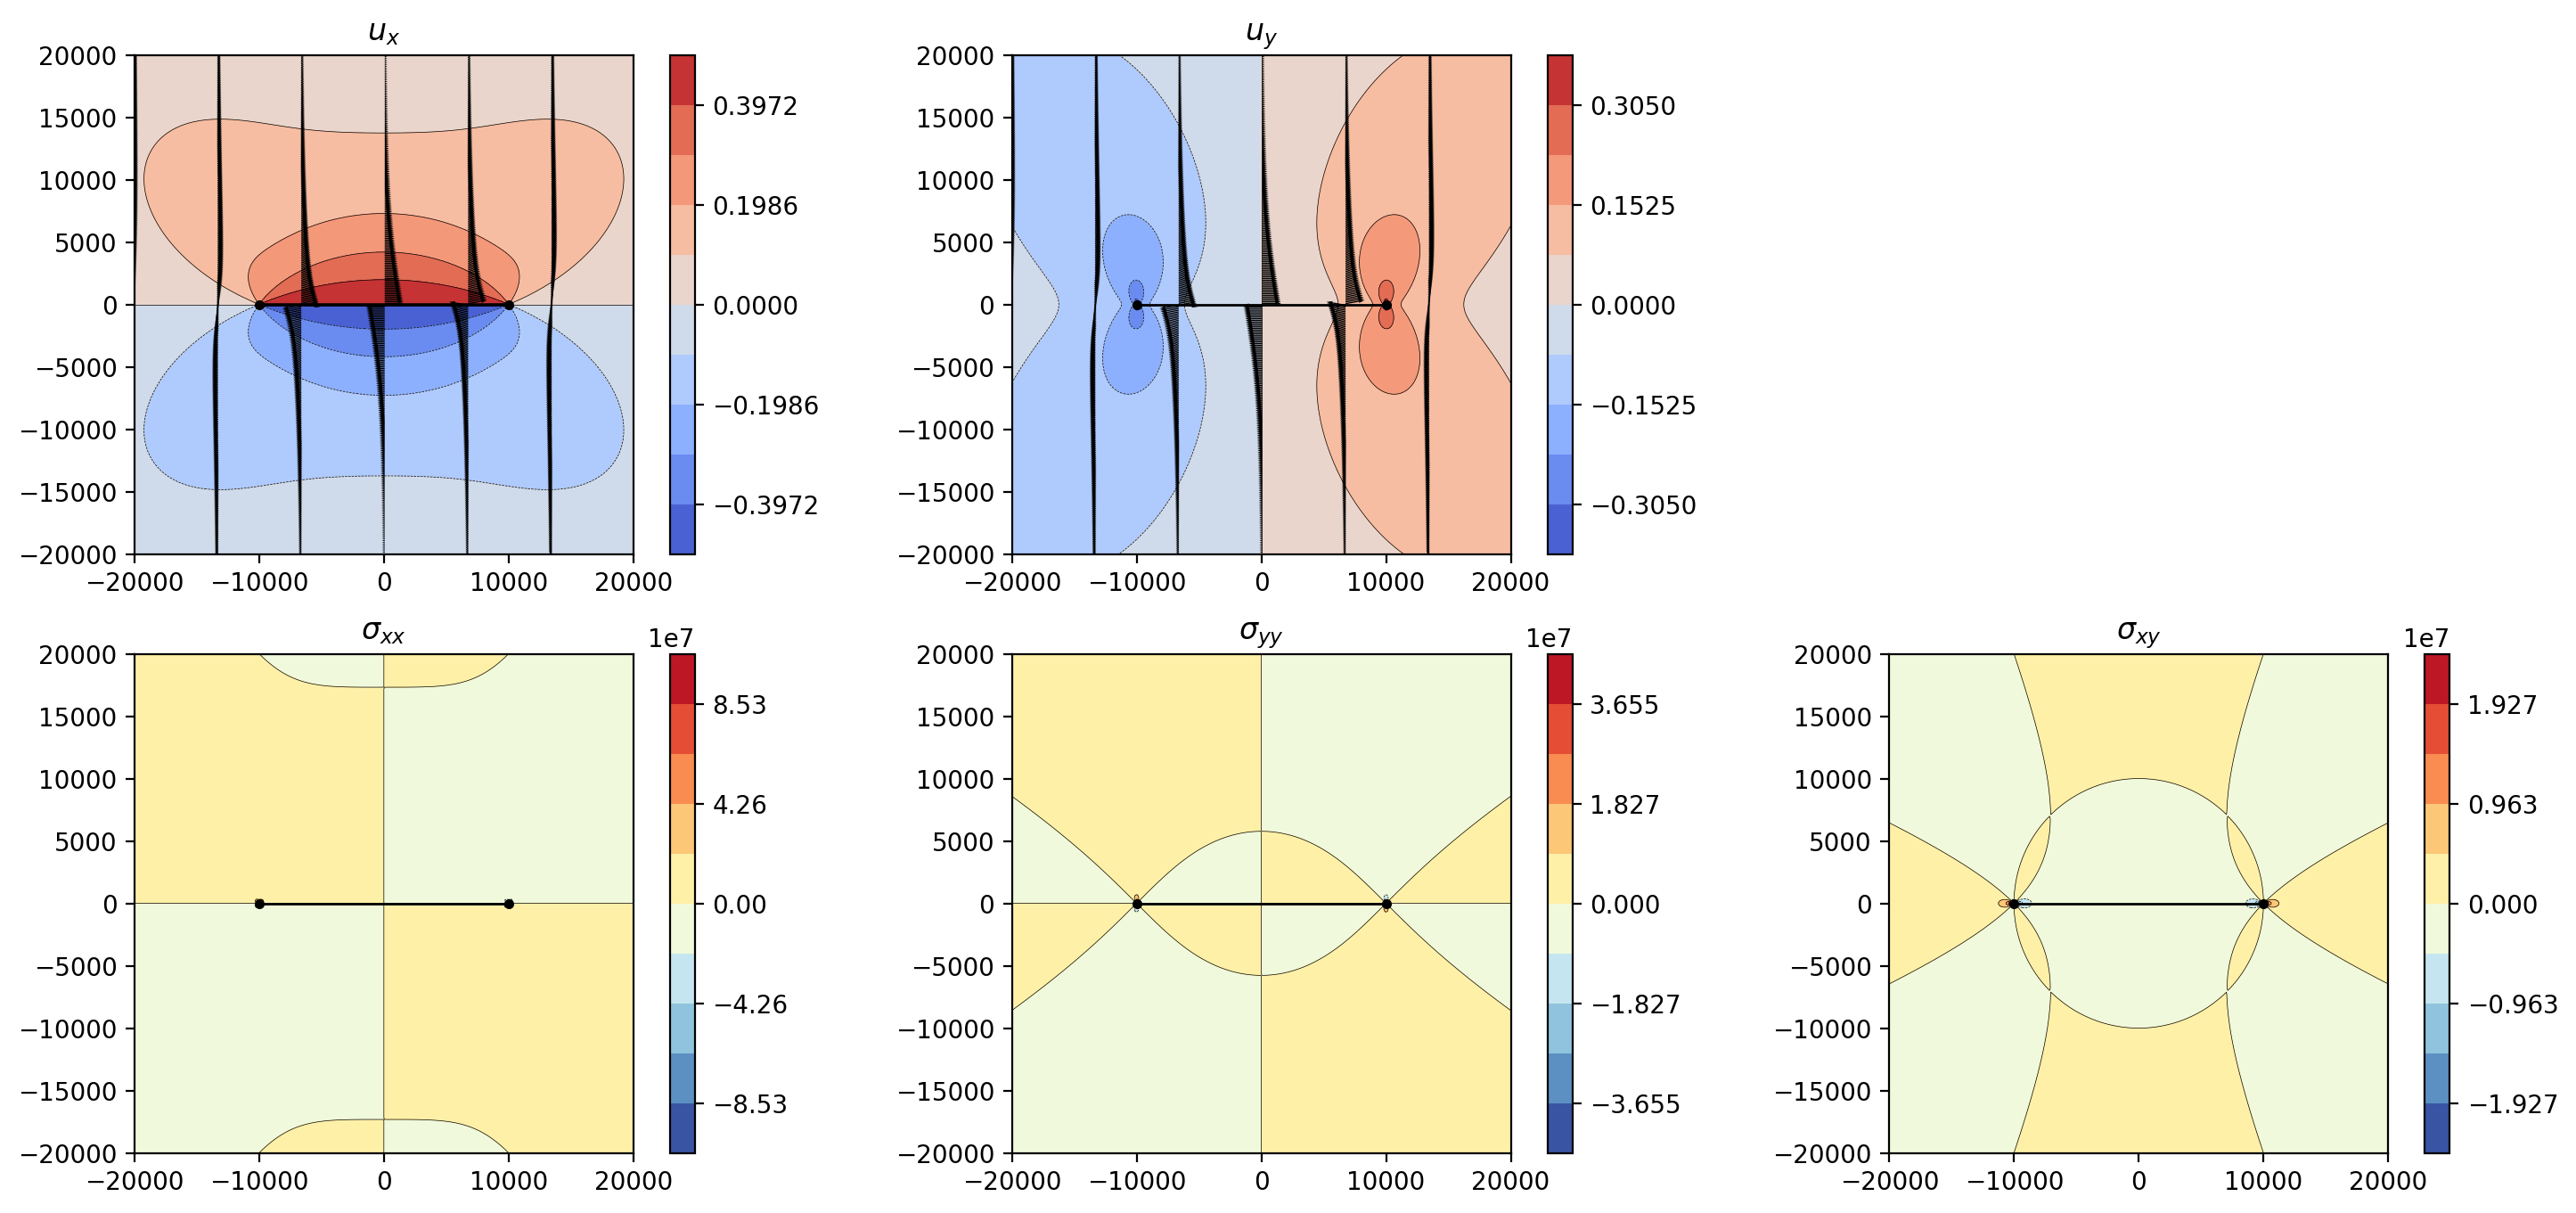

In [8]:
strike_slip_constant = 1
tensile_slip_constant = 0

(
    displacement_constant,
    stress_constant,
) = bemcs.displacements_stresses_constant_no_rotation(
    x_obs,
    y_obs,
    els.half_lengths[0],
    mu,
    nu,
    strike_slip_constant,
    tensile_slip_constant,
    els.x_centers[0],
    els.y_centers[0],
)

ux = displacement_constant[0, :]
uy = displacement_constant[1, :]
sxx = stress_constant[0, :]
syy = stress_constant[1, :]
sxy = stress_constant[2, :]

bemcs.plot_displacements_stresses_els(
    els, n_pts, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=50
)

# Calculate and plot strain energy

conversion='plane_strain'
[[ 1.25000000e-11 -4.16666667e-12  0.00000000e+00]
 [-4.16666667e-12  1.25000000e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33333333e-11]]
conversion='plane_stress'
[[ 1.33333333e-11 -3.33333333e-12  0.00000000e+00]
 [-3.33333333e-12  1.33333333e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33333333e-11]]


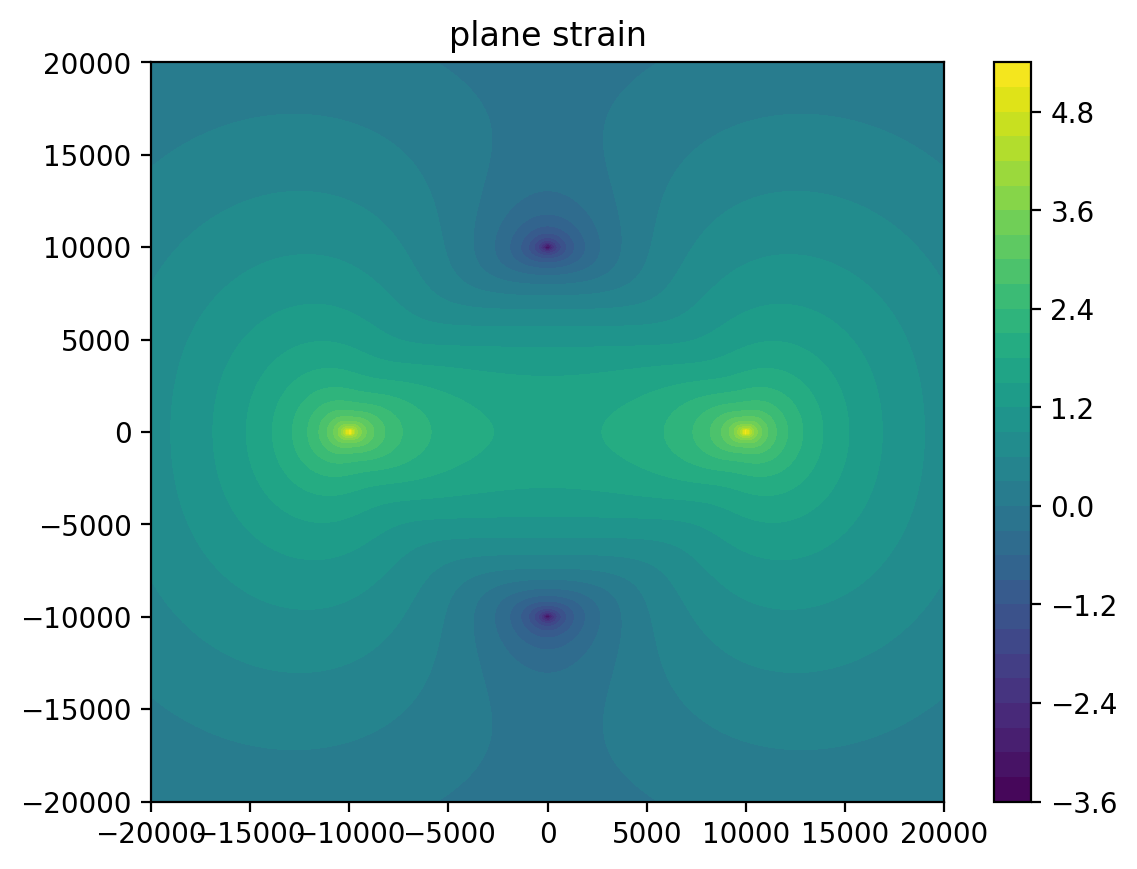

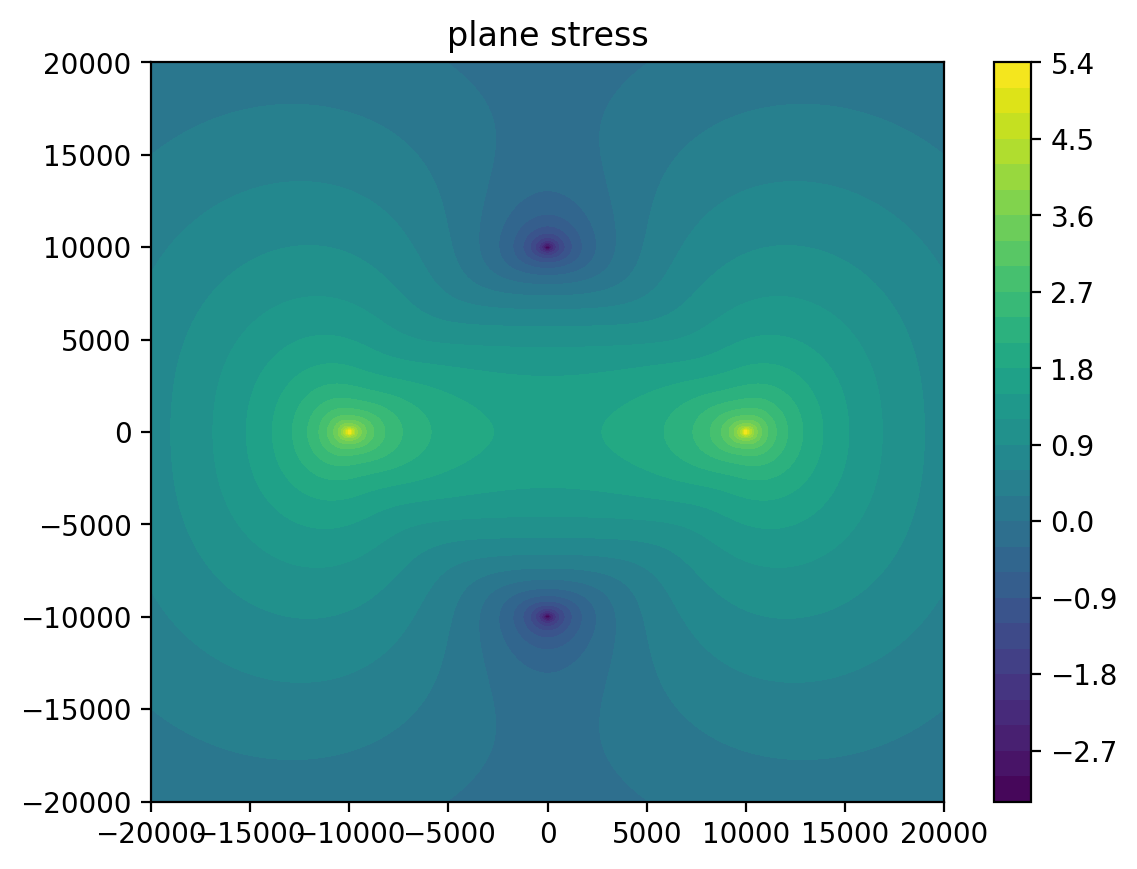

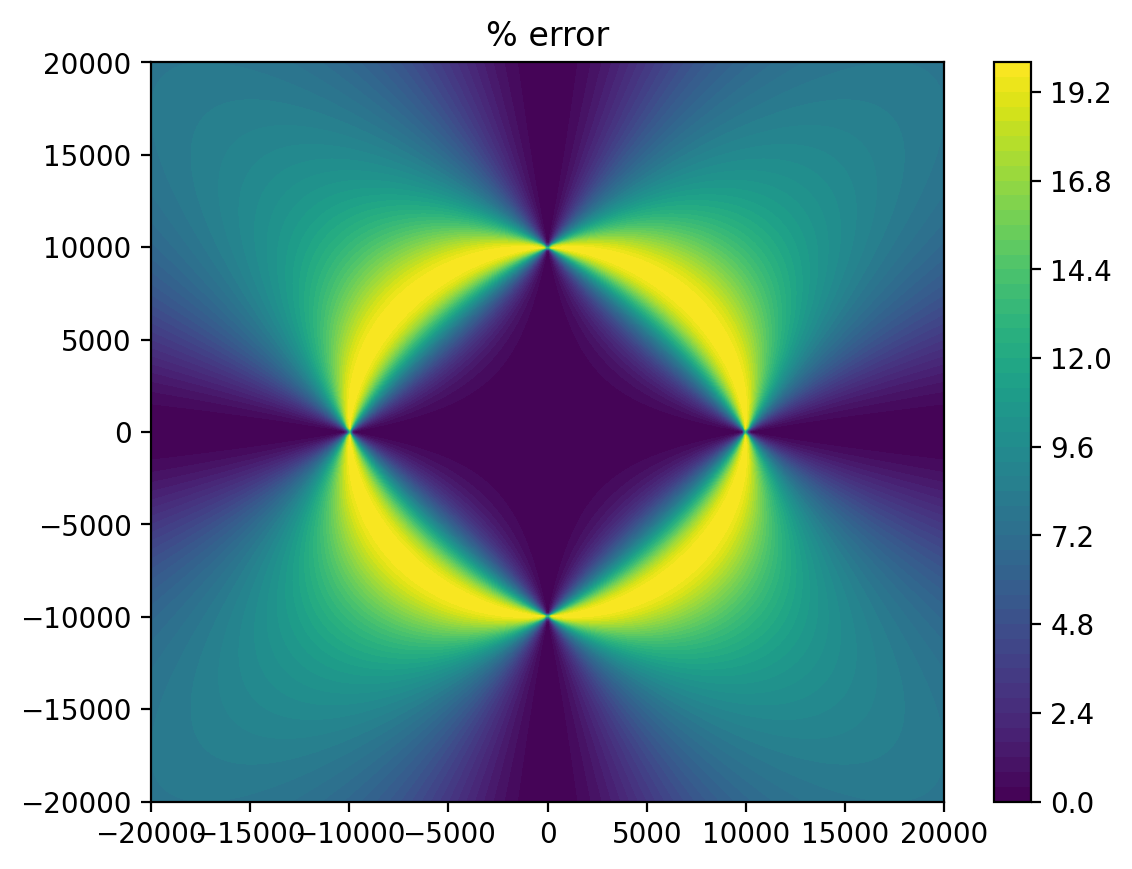

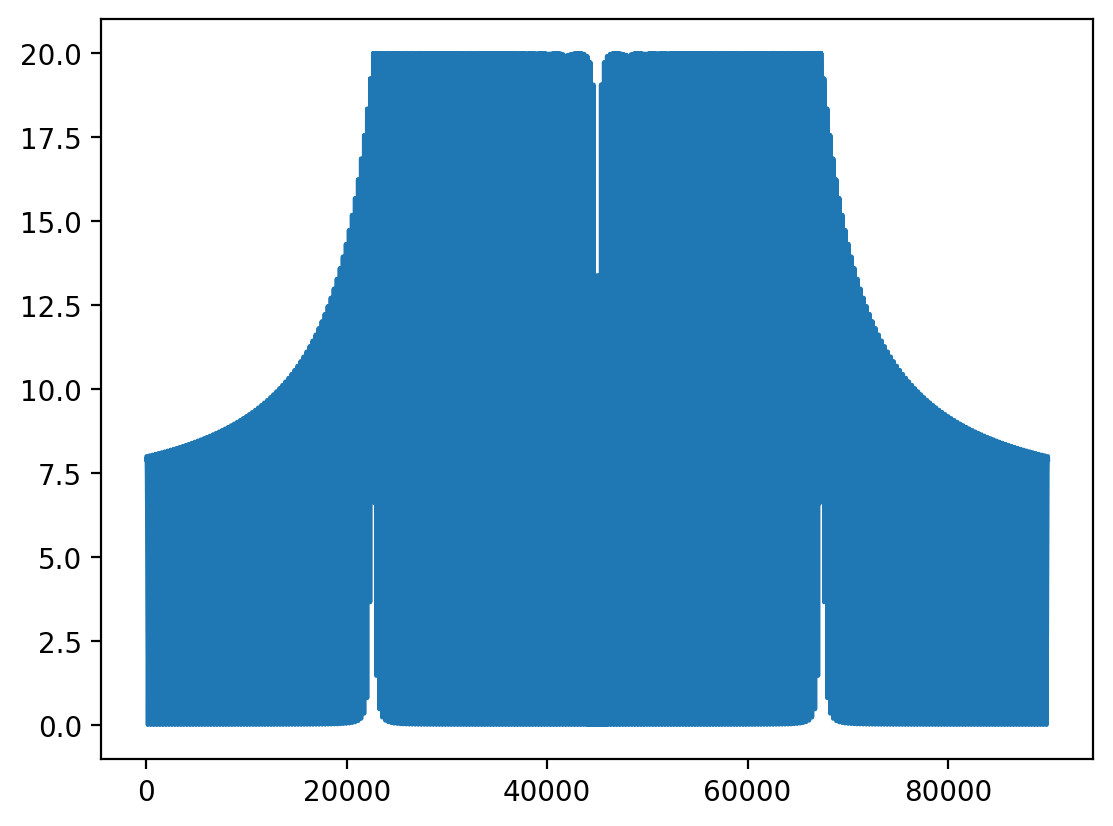

In [5]:
# Calculate strain from stress...strange times


def get_strain_from_stress(sxx, syy, sxy, mu, nu, conversion="plane_strain"):
    youngs_modulus = 2 * mu * (1 + nu)

    if conversion == "plane_strain":
        print(f"{conversion=}")
        # Plane strain linear operator. I think this is Crouch and Starfield???
        stress_from_strain_plane_strain = (
            youngs_modulus
            / ((1 + nu) * (1 - 2 * nu))
            * np.array([[1 - nu, nu, 0], [nu, 1 - nu, 0], [0, 0, (1 - 2 * nu) / 2.0]])
        )
        strain_from_stress_plane_strain = np.linalg.inv(stress_from_strain_plane_strain)
        operator = np.copy(strain_from_stress_plane_strain)

    elif conversion == "plane_stress":
        print(f"{conversion=}")
        # Plane stress linear operator
        strain_from_stress_plane_stress = (
            1
            / youngs_modulus
            * np.array([[1, -nu, 0], [-nu, 1, 0], [0, 0, 2 * (1 + nu)]])
        )
        operator = np.copy(strain_from_stress_plane_stress)

    print(f"{operator}")

    # Calculate strains
    exx = np.zeros_like(sxx)
    exy = np.zeros_like(syy)
    eyy = np.zeros_like(sxy)
    for i in range(len(sxx)):
        stresses = np.array([sxx[i], syy[i], sxy[i]])
        exx[i], eyy[i], exy[i] = operator @ stresses

    # Calculate strain energy
    strain_energy = sxx * exx + syy * eyy + sxy * exy
    return strain_energy


strain_energy_plane_strain = get_strain_from_stress(
    sxx, syy, sxy, mu, nu, conversion="plane_strain"
)
strain_energy_plane_stress = get_strain_from_stress(
    sxx, syy, sxy, mu, nu, conversion="plane_stress"
)

# Plt strain energy
plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    np.log10(np.abs(strain_energy_plane_strain.reshape(n_pts, n_pts))),
    levels=30,
)
plt.colorbar()
plt.title("plane strain")
plt.show()

plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    np.log10(np.abs(strain_energy_plane_stress.reshape(n_pts, n_pts))),
    levels=30,
)
plt.colorbar()
plt.title("plane stress")
plt.show()

# Residual
residual = np.abs(
    (
        strain_energy_plane_strain.reshape(n_pts, n_pts)
        - strain_energy_plane_stress.reshape(n_pts, n_pts)
    )
    / strain_energy_plane_strain.reshape(n_pts, n_pts)
    * 100
)

plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    residual,
    levels=50,
)
plt.colorbar()
plt.title("% error")
plt.show()

plt.figure()
plt.plot(residual.flatten())
plt.show()

# Why is there a sign change in $\sigma_{xy}$ with distance perpendicular to the fault trace?

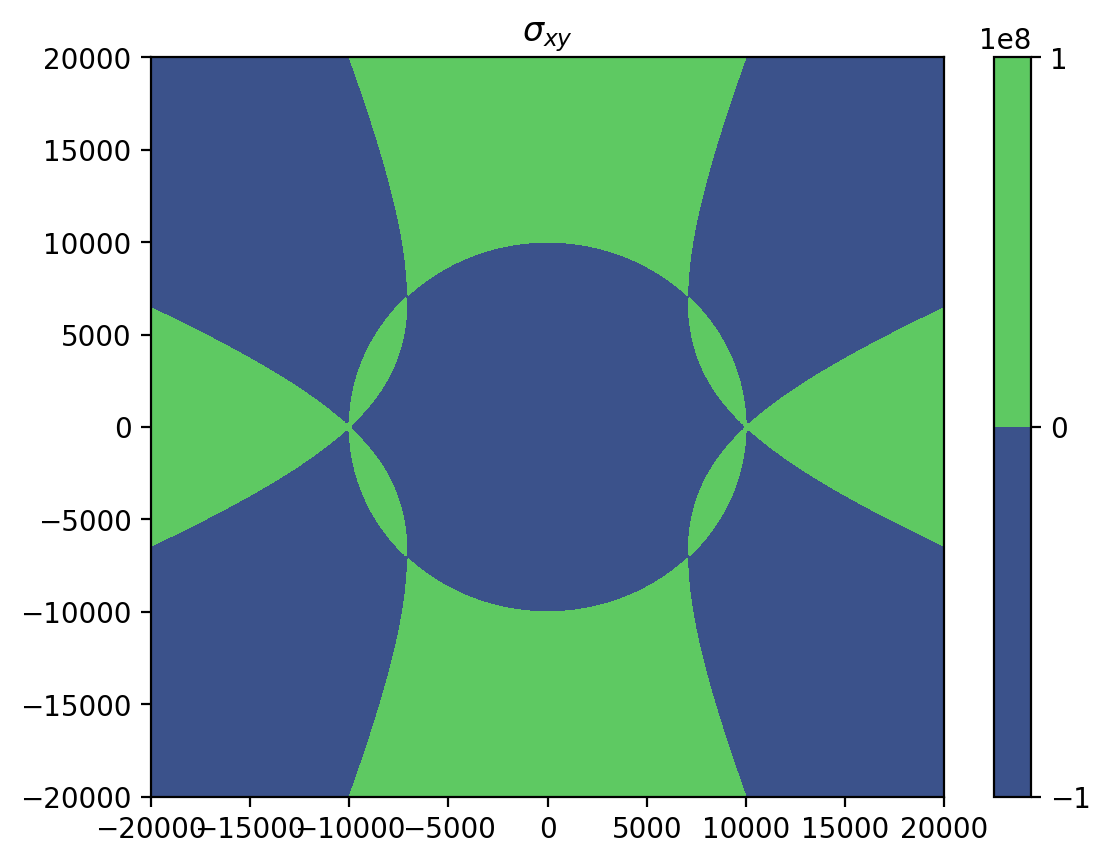

In [6]:
plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    sxy.reshape(n_pts, n_pts),
    levels=[-1e8, 0, 1e8],
)
plt.colorbar()
plt.title("$\sigma_{xy}$")
plt.show()